# NSQIP - LASSO Regression
---

Regressing on all of our predictors at once will tend to produce an over-fitted model. A traditional approach to this is to use a stepwise selection procedure, fitting individual best-fitting terms in sequence and adding them to build up a model in an interative fashion. These models are pretty common in the literature, but statisticians tend not to like them for a variety of reasons. Some of these are technical, but a pretty basic reason is that doing dozens of repeated statistical tests makes the meaning of each statistical test not very valid.

A more modern approach is to use a regularization term in the regression that penalizes the model based on the size of coefficients. Popular ways of doing this include Ridge Regression, Lasso Regression, and Elastic Net Regression. Ridge Regression uses a penalty based on the $L^2$ norm of the vector of coefficients (which is just the euclidean length of the coefficient vector). Lasso Regression uses a penalty based on the $L^1$ norm (which is the sum of the absolute values of the coefficients). Elastic Net Regression uses a combination of $L^1$ and $L^2$ penalties. Given covarying predictors, Lasso regression will tend to fit based on one of them, and shrink the others to zero, giving a sparse model. More information can be found here: 

[Tibshirani, R. (1996). Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society. Series B (Methodological), 267-288.](http://www.jstor.org.ezp-prod1.hul.harvard.edu/stable/2346178)

Begin with imports of key libraries, and load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as sklm
import warnings 
warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

Next, determine which response and predictor columns we want to use.

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = False
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add FNSTATUS1 and RBC
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]

These regression models will fail on missing data, so we'll impute missing data for each column by setting it equal to the mean.

Since our regularization penalty is based on the size of the coefficients, we need to scale each column to have approximately equal mean and variance. We also add an intercept column.

In [3]:
# Add an intercept
cdf['intercept'] = 1.0

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

# Scale the columns
X = StandardScaler().fit_transform(cdf)
scaledX = pd.DataFrame(X, columns=colNames)

We break the data into separate fractions for training and testing. All of our fitting and cross-validation will be done on the training set. The testing set will be held out to evaluate the final model performance.

In [4]:
# Split for cross-validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.33)

Create a LogisticRegression object with $L^1$ regularization.

In [5]:
# C is regularization strength, smaller is stronger
lr = LogisticRegression(C=0.01, penalty='l1', tol=0.01) # Use L1, for LASSO

Now we need to determine the appropriate value of the regularization strength $C$. To do this we'll do a cross-validated grid search, trying different values of $C$, and calculating the ROC AUC on the held-out cross-validation fraction. (Nb. This is not using the 'test' data held out above.)

In [6]:
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': np.logspace(-2.5,-.5,20,base=10)}]
gscv = GridSearchCV(lr, tuned_parameters, cv=10,scoring='roc_auc',verbose=1)
gscv.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   10.1s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   10.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.01,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': array([ 0.01   ,  0.01129,  0.01274,  0.01438,  0.01624,  0.01833,
        0.02069,  0.02336,  0.02637,  0.02976,  0.0336 ,  0.03793,
        0.04281,  0.04833,  0.05456,  0.06158,  0.06952,  0.07848,
        0.08859,  0.1    ])}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

Now plot the mean cross-validated AUC for each value of $C$ we tried. The model will use the best value of $C$ (dotted line).

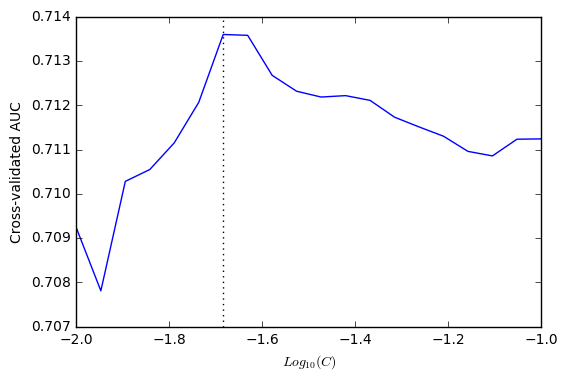

In [7]:
gscv.grid_scores_
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params['C'] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means)
bestC = gscv.best_params_['C']
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}(C)$')
plt.ylabel('Cross-validated AUC')
plt.show()


Plot ROC curves for in-sample training data, and test data. The test data here was not used to fit the model at all, so it should approximate how our model will perform prospectively on new data.

In-sample ROC AUC = 0.730 
Test ROC AUC = 0.744 


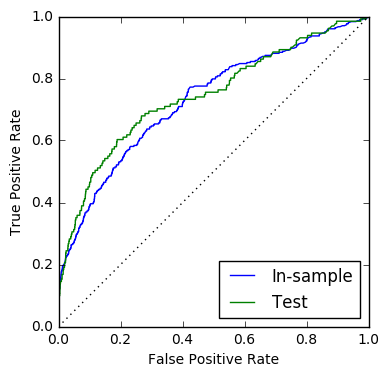

In [8]:
# Plot an ROC curve for training
plt.clf
pred_train = gscv.predict_proba(X_train)[:,1]
rocAUC_train = sklm.roc_auc_score(y_train,pred_train)
print('In-sample ROC AUC = %.3f ' % rocAUC_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_train)
plt.figure()
plt.plot(fpr,tpr,label='In-sample')

# Plot an ROC curve for test data
pred_test = gscv.predict_proba(X_test)[:,1]
rocAUC_test = sklm.roc_auc_score(y_test,pred_test)
print('Test ROC AUC = %.3f ' % rocAUC_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_test)
plt.plot(fpr,tpr,label='Test')

# Format the ROC plot
plt.plot([0, 1], [0, 1], color='k', linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.show()

Now print the model coefficients. (Remember that these have been pre-scaled above. For them to be useful with natural units we need to un-scale them.)

In [9]:
# Print out all the non-zero coefficients
bestEst = gscv.best_estimator_
coeffs = bestEst.coef_.ravel()
coeffIdx = np.nonzero(coeffs != 0)[0]
for idx in coeffIdx:
    print('Coeff: %.3f \t %s' % (coeffs[idx], cdf.columns[idx]))

Coeff: 0.181 	 AGE
Coeff: 0.036 	 CNSCVA-No Complication
Coeff: -0.018 	 DCNSCVA-0.0
Coeff: 0.025 	 DIABETES-INSULIN
Coeff: -0.117 	 DIABETES-NO
Coeff: 0.054 	 DIALYSIS-Yes
Coeff: 0.002 	 DWNDINFD
Coeff: -0.046 	 DYSPNEA-No
Coeff: 0.002 	 HXPVD-Yes
Coeff: 0.088 	 NWNDINFD-0
Coeff: -0.124 	 PRALBUM
Coeff: 0.066 	 PRALKPH
Coeff: 0.033 	 PRCREAT
Coeff: 0.022 	 PRINR
Coeff: -0.147 	 WNDINFD-Deep Incisional SSI


We need to find some way here to determine confidence intervals on these. One way might just be to take the variables selected by LASSO and put them into a standard multivariate logistic regression. Another way might be to estimate confidence intervals and p-values by bootstrapping the LASSO. This might be hard to do correctly, though. Some references:

Lee, J. D., Sun, D. L., Sun, Y., & Taylor, J. E. (2016). Exact post-selection inference, with application to the lasso. The Annals of Statistics, 44(3), 907-927.

Efron, B. (2014). Estimation and accuracy after model selection. Journal of the American Statistical Association, 109(507), 991-1007.

Chatterjee, A., & Lahiri, S. N. (2011). Bootstrapping lasso estimators. Journal of the American Statistical Association, 106(494), 608-625.

